In [19]:
# %load withholding.py
# %matplotlib notebook
import matplotlib as plt
import numpy as np
import pandas as pd

import seaborn as sns

# Apply the default theme
sns.set_theme()

df = pd.read_csv("../../data/withholding.tsv", sep="\t")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]


def parse_array(s):
    try:
        return np.fromstring(s, dtype=float, sep="|")
    except:
        return np.array([float("nan")])


def expand(row):
    compute = parse_array(row.compute)
    rcompute = compute / np.sum(compute)
    activations = parse_array(row.activations)
    assert np.sum(activations) == row.number_activations or row.error
    ractivations = activations / row.number_activations
    reward = parse_array(row.reward)
    rreward = reward / np.sum(reward)
    d = {}
    d["attack_space"] = row["strategy"].split("-")[0]
    d["policy"] = "-".join(row["strategy"].split("-")[1:])
    d["attacker_compute"] = rcompute[0]
    d["attacker_relative_activations"] = ractivations[0]
    d["attacker_relative_reward"] = rreward[0]
    d["attacker_gain"] = rreward[0] - ractivations[0]
    d["attacker_reward"] = reward[0]
    d["attacker_reward_per_time"] = reward[0] / row.ca_time
    # simulate DAA restrospectively. This method works only for zero network delays.
    d["da_observed_pow_interval"] = row.ca_time / (row.ca_height * row.k)
    d["da_target_pow_interval"] = 1
    d["da_ca_time"] = (
        row.ca_time / d["da_observed_pow_interval"] * d["da_target_pow_interval"]
    )
    d["da_attacker_reward_per_time"] = reward[0] / d["da_ca_time"]
    return d


df = df.join(df.apply(expand, axis=1, result_type="expand"))

d = df.query('protocol in ["tailstormll", "tailstorm"]')
d = d[(d.incentive_scheme == "constant") | (d.incentive_scheme == "discount")]
d.columns

Index(['network', 'network_description', 'compute', 'protocol', 'k',
       'protocol_description', 'block_interval', 'activation_delay',
       'number_activations', 'activations', 'incentive_scheme',
       'incentive_scheme_description', 'strategy', 'strategy_description',
       'reward', 'ca_time', 'ca_height', 'machine_duration_s', 'error',
       'version', 'attack_space', 'policy', 'attacker_compute',
       'attacker_relative_activations', 'attacker_relative_reward',
       'attacker_gain', 'attacker_reward', 'attacker_reward_per_time',
       'da_observed_pow_interval', 'da_target_pow_interval', 'da_ca_time',
       'da_attacker_reward_per_time'],
      dtype='object')

In [20]:
d.pivot(
    index=["network", "attacker_compute", "k"],
    columns=["protocol", "strategy", "incentive_scheme"],
    values="attacker_relative_reward",
)

protocol                                  tailstorm                     \
strategy                       ssz-override-catchup ssz-override-block   
incentive_scheme                           constant           constant   
network    attacker_compute k                                            
gamma-0    0.1              1              0.033837           0.034084   
                            2              0.036312           0.033769   
                            4              0.037171           0.032194   
                            8              0.031716           0.031497   
                            16             0.025968           0.028660   
...                                             ...                ...   
two-agents 0.5              2              0.989899           0.596192   
                            4              0.791013           0.602752   
                            8              0.978621           0.622893   
                            16             0.879389           0.655391   
                            32             0.755006           0.671875   

protocol                                                     \
strategy                       ssz-release-block ssz-honest   
incentive_scheme                        constant   constant   
network    attacker_compute k                                 
gamma-0    0.1              1            0.09800   0.093532   
                            2            0.10170   0.100800   
                            4            0.09770   0.102800   
                            8            0.09830   0.094300   
                            16           0.09710   0.098600   
...                                          ...        ...   
two-agents 0.5              2            0.50110   0.509400   
                            4            0.49810   0.495100   
                            8            0.50210   0.509900   
                            16           0.50550   0.499700   
                            32           0.49359   0.501603   

protocol                                                                \
strategy                       ssz-override-catchup ssz-override-block   
incentive_scheme                           discount           discount   
network    attacker_compute k                                            
gamma-0    0.1              1              0.034980           0.036397   
                            2              0.031019           0.030024   
                            4              0.029264           0.035132   
                            8              0.026146           0.027492   
                            16             0.027711           0.026965   
...                                             ...                ...   
two-agents 0.5              2              0.853625           0.600329   
                            4              0.835360           0.612500   
                            8              0.950578           0.638726   
                            16             0.718790           0.662233   
                            32             0.840146           0.667669   

protocol                                                     \
strategy                       ssz-release-block ssz-honest   
incentive_scheme                        discount   discount   
network    attacker_compute k                                 
gamma-0    0.1              1           0.102500   0.091607   
                            2           0.082966   0.099015   
                            4           0.084526   0.100045   
                            8           0.089574   0.102485   
                            16          0.091840   0.101462   
...                                          ...        ...   
two-agents 0.5              2           0.498516   0.487752   
                            4           0.496105   0.496240   
                            8           0.495381   0.493785   
             

Check if orphans align across discount schemes (Tailstorm/ll)

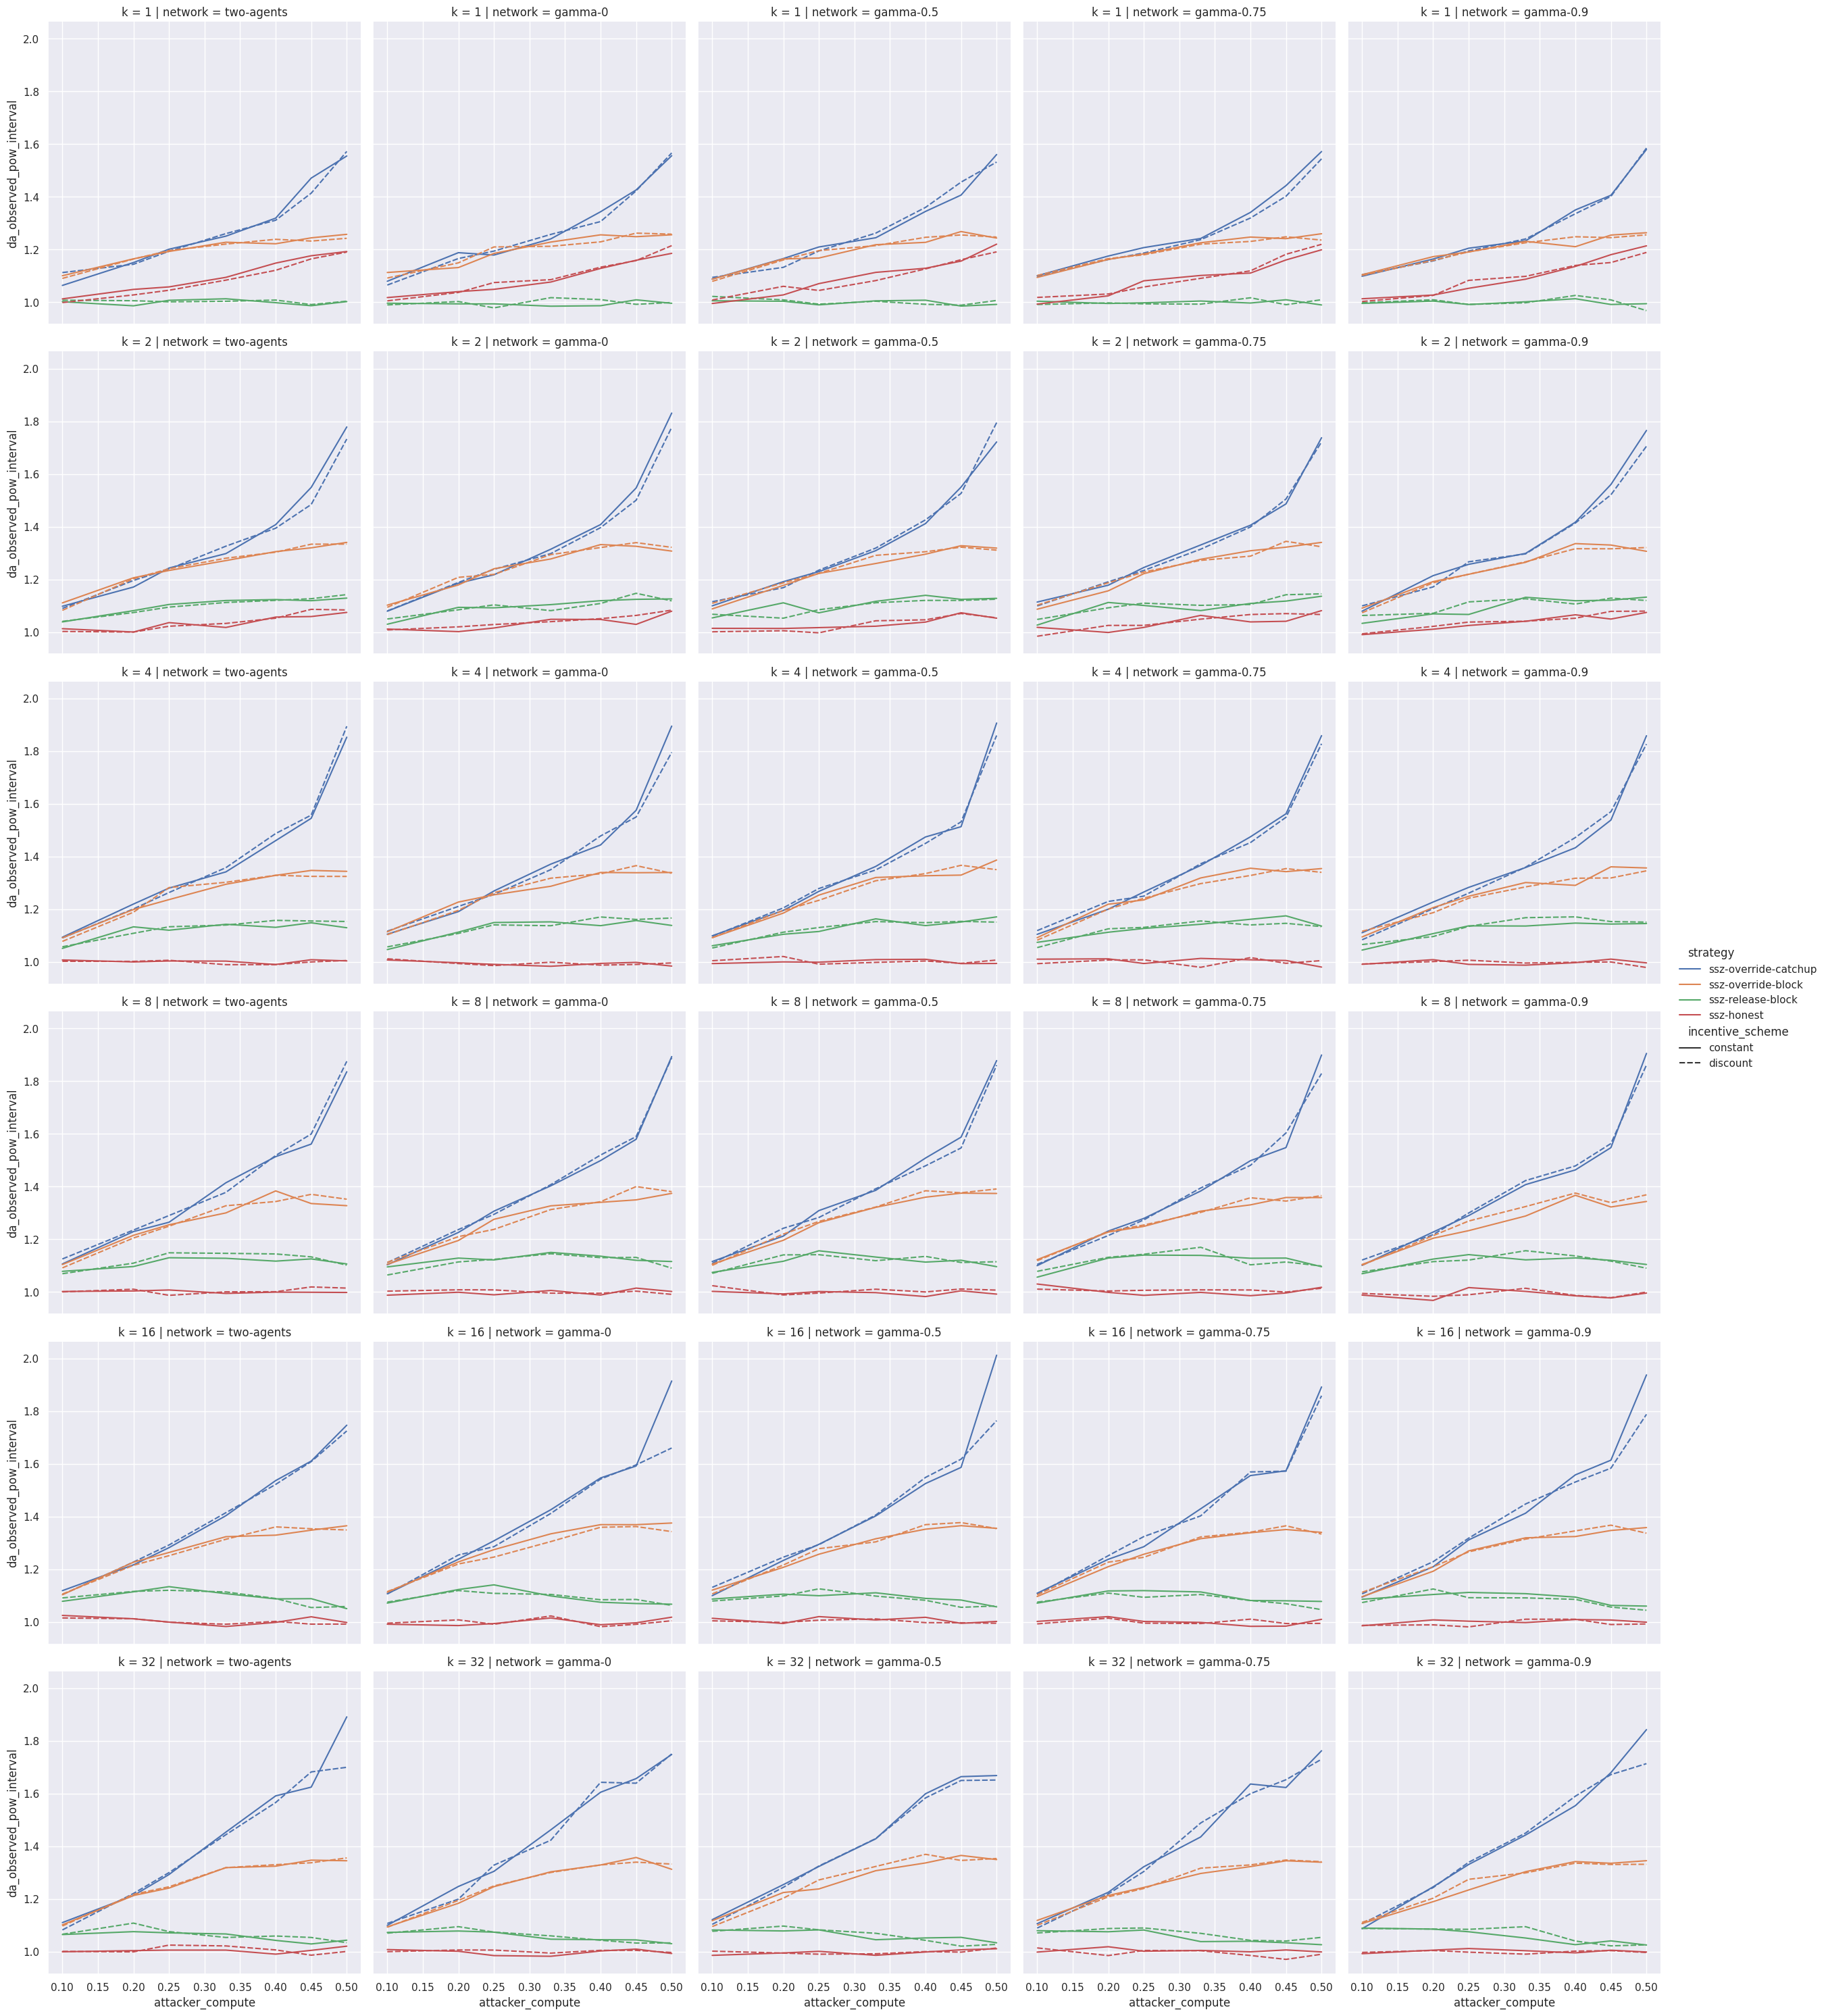

In [25]:
ax = sns.relplot(
    data=d.query('attack_space == "ssz" and protocol == "tailstormll"'),
    x="attacker_compute",
    y="da_observed_pow_interval",
    col="network",
    row="k",
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)

Check if orphans align across discount schemes (Tailstorm)

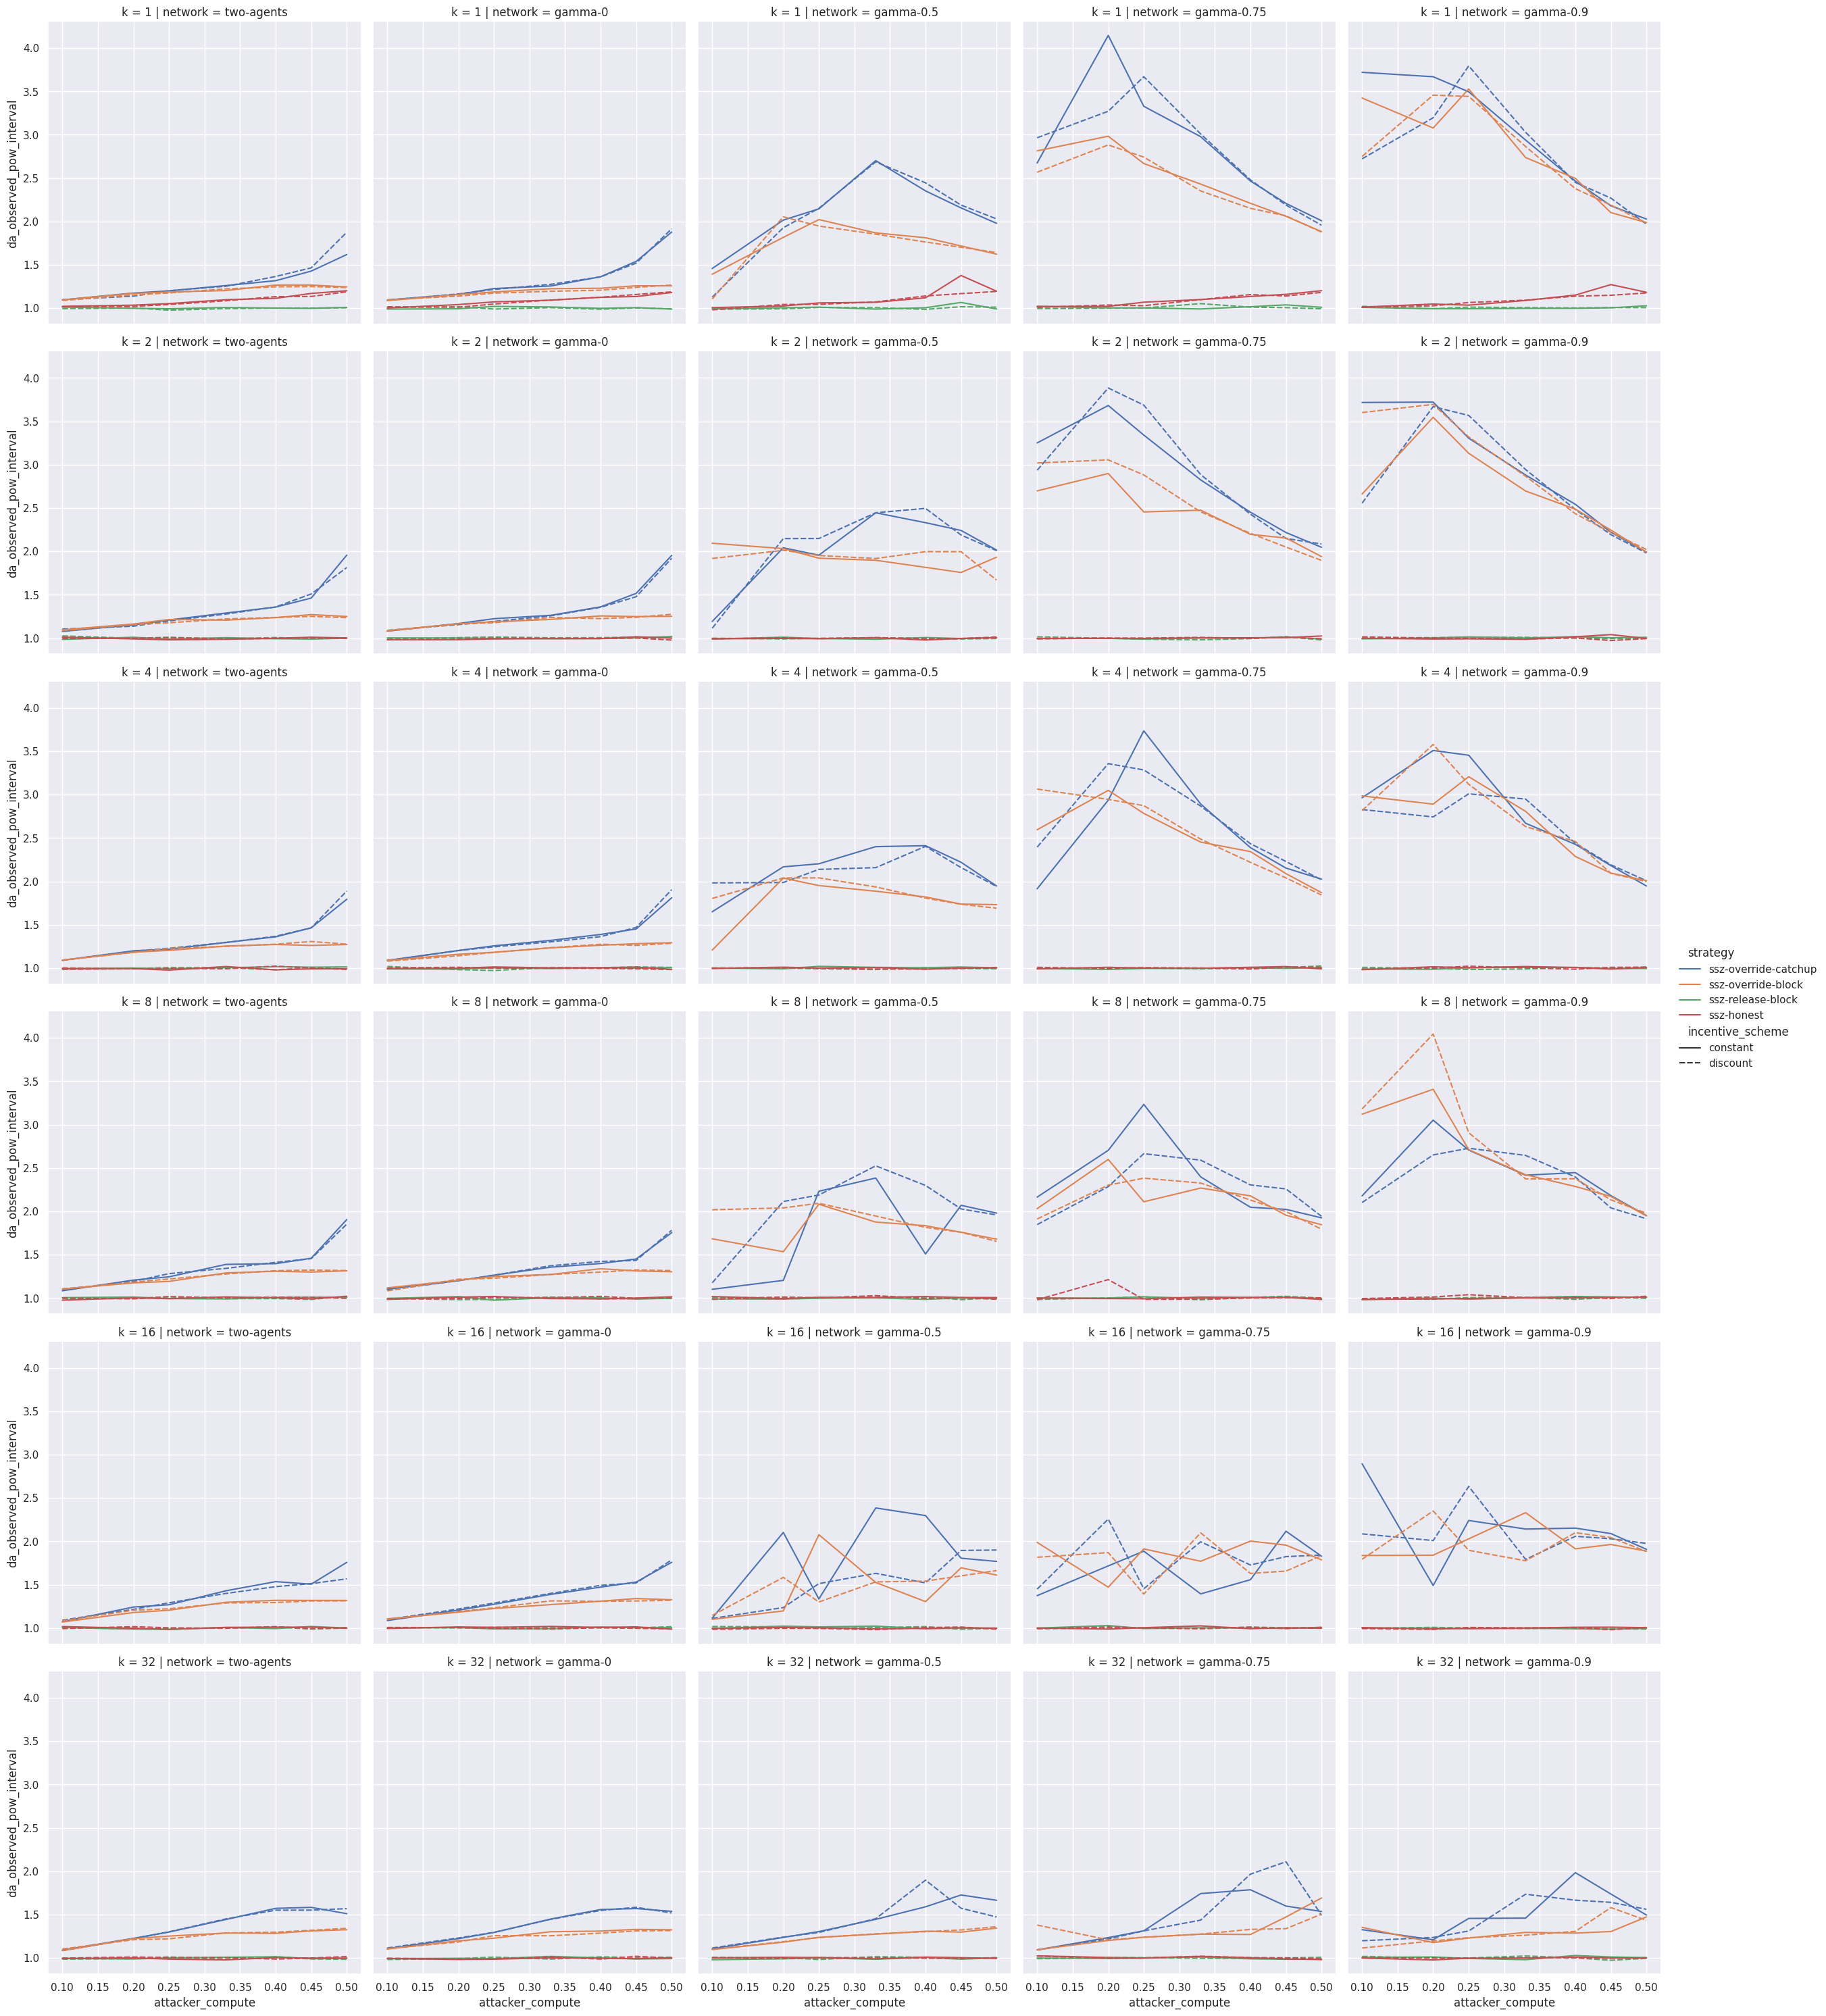

In [24]:
ax = sns.relplot(
    data=d.query('attack_space == "ssz" and protocol == "tailstorm"'),
    x="attacker_compute",
    y="da_observed_pow_interval",
    col="network",
    row="k",
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)

There seems to be no difference between the incenctive schemes. This is good.

Unfortunately, there seems to be a huge difference between the protocol implementations.

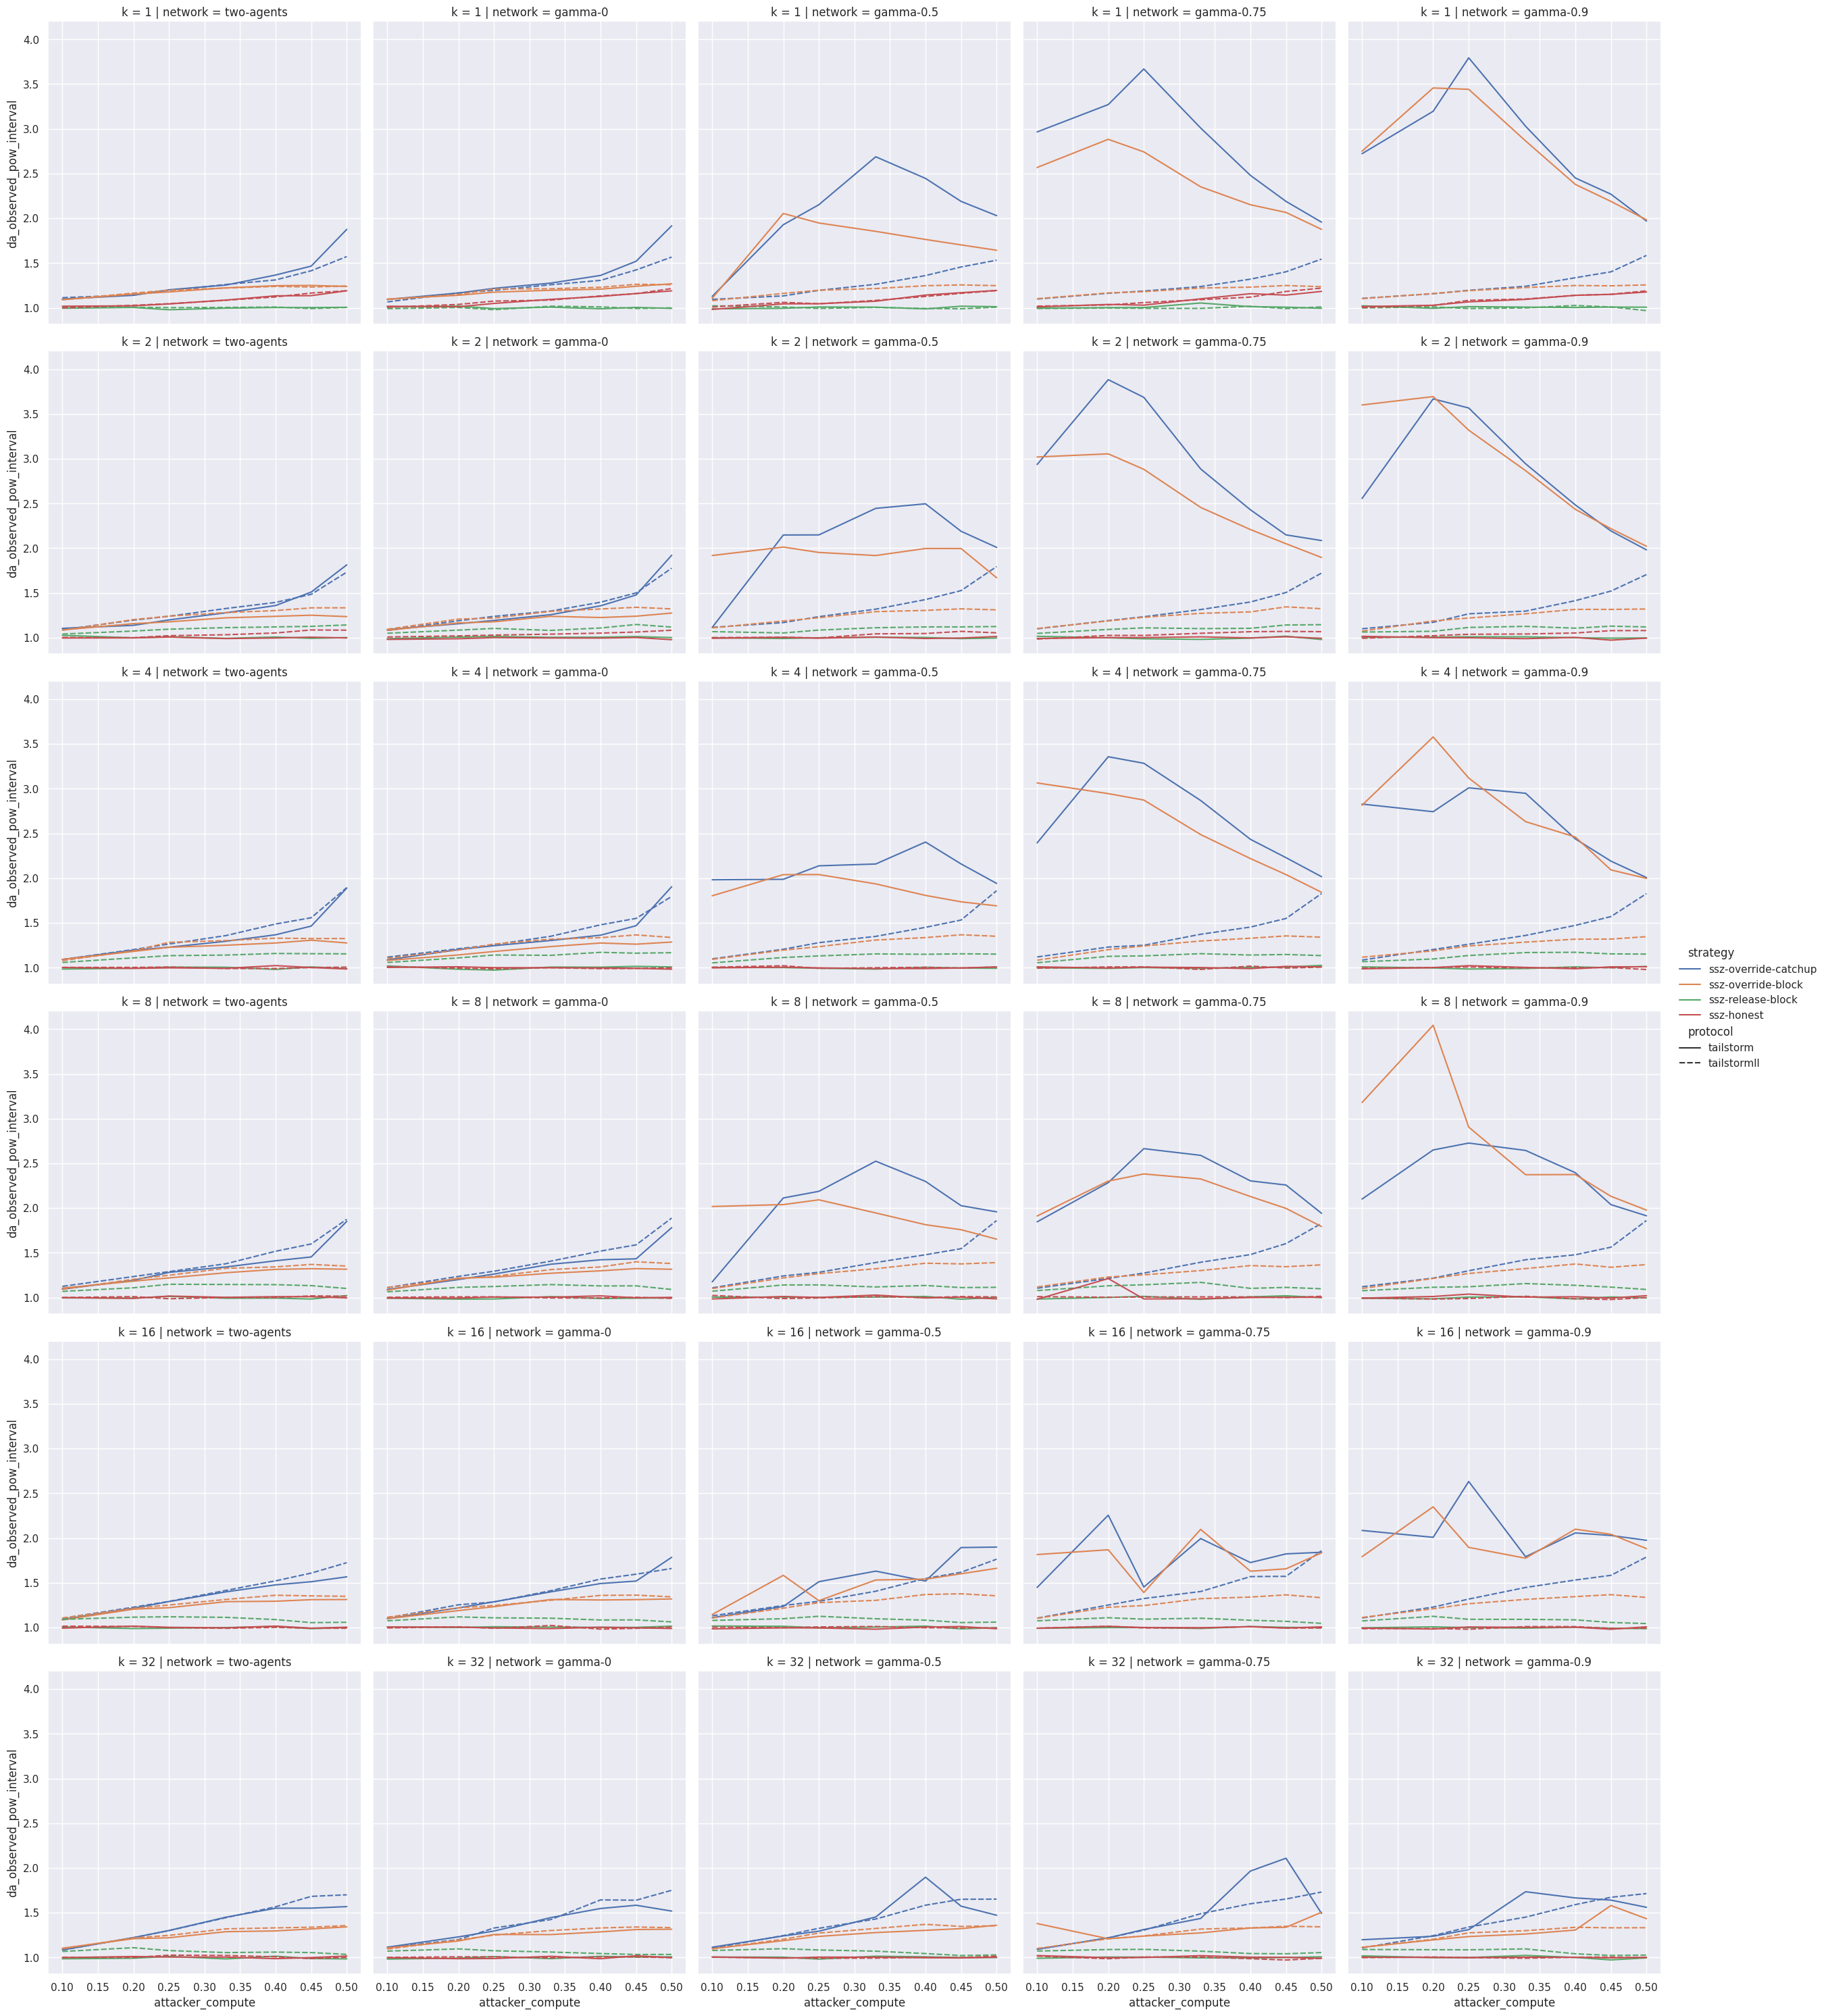

In [27]:
ax = sns.relplot(
    data=d.query('attack_space == "ssz" and incentive_scheme == "discount"'),
    x="attacker_compute",
    y="da_observed_pow_interval",
    col="network",
    row="k",
    hue="strategy",
    style="protocol",
    kind="line",
)

Let's have a look whether there are long forks

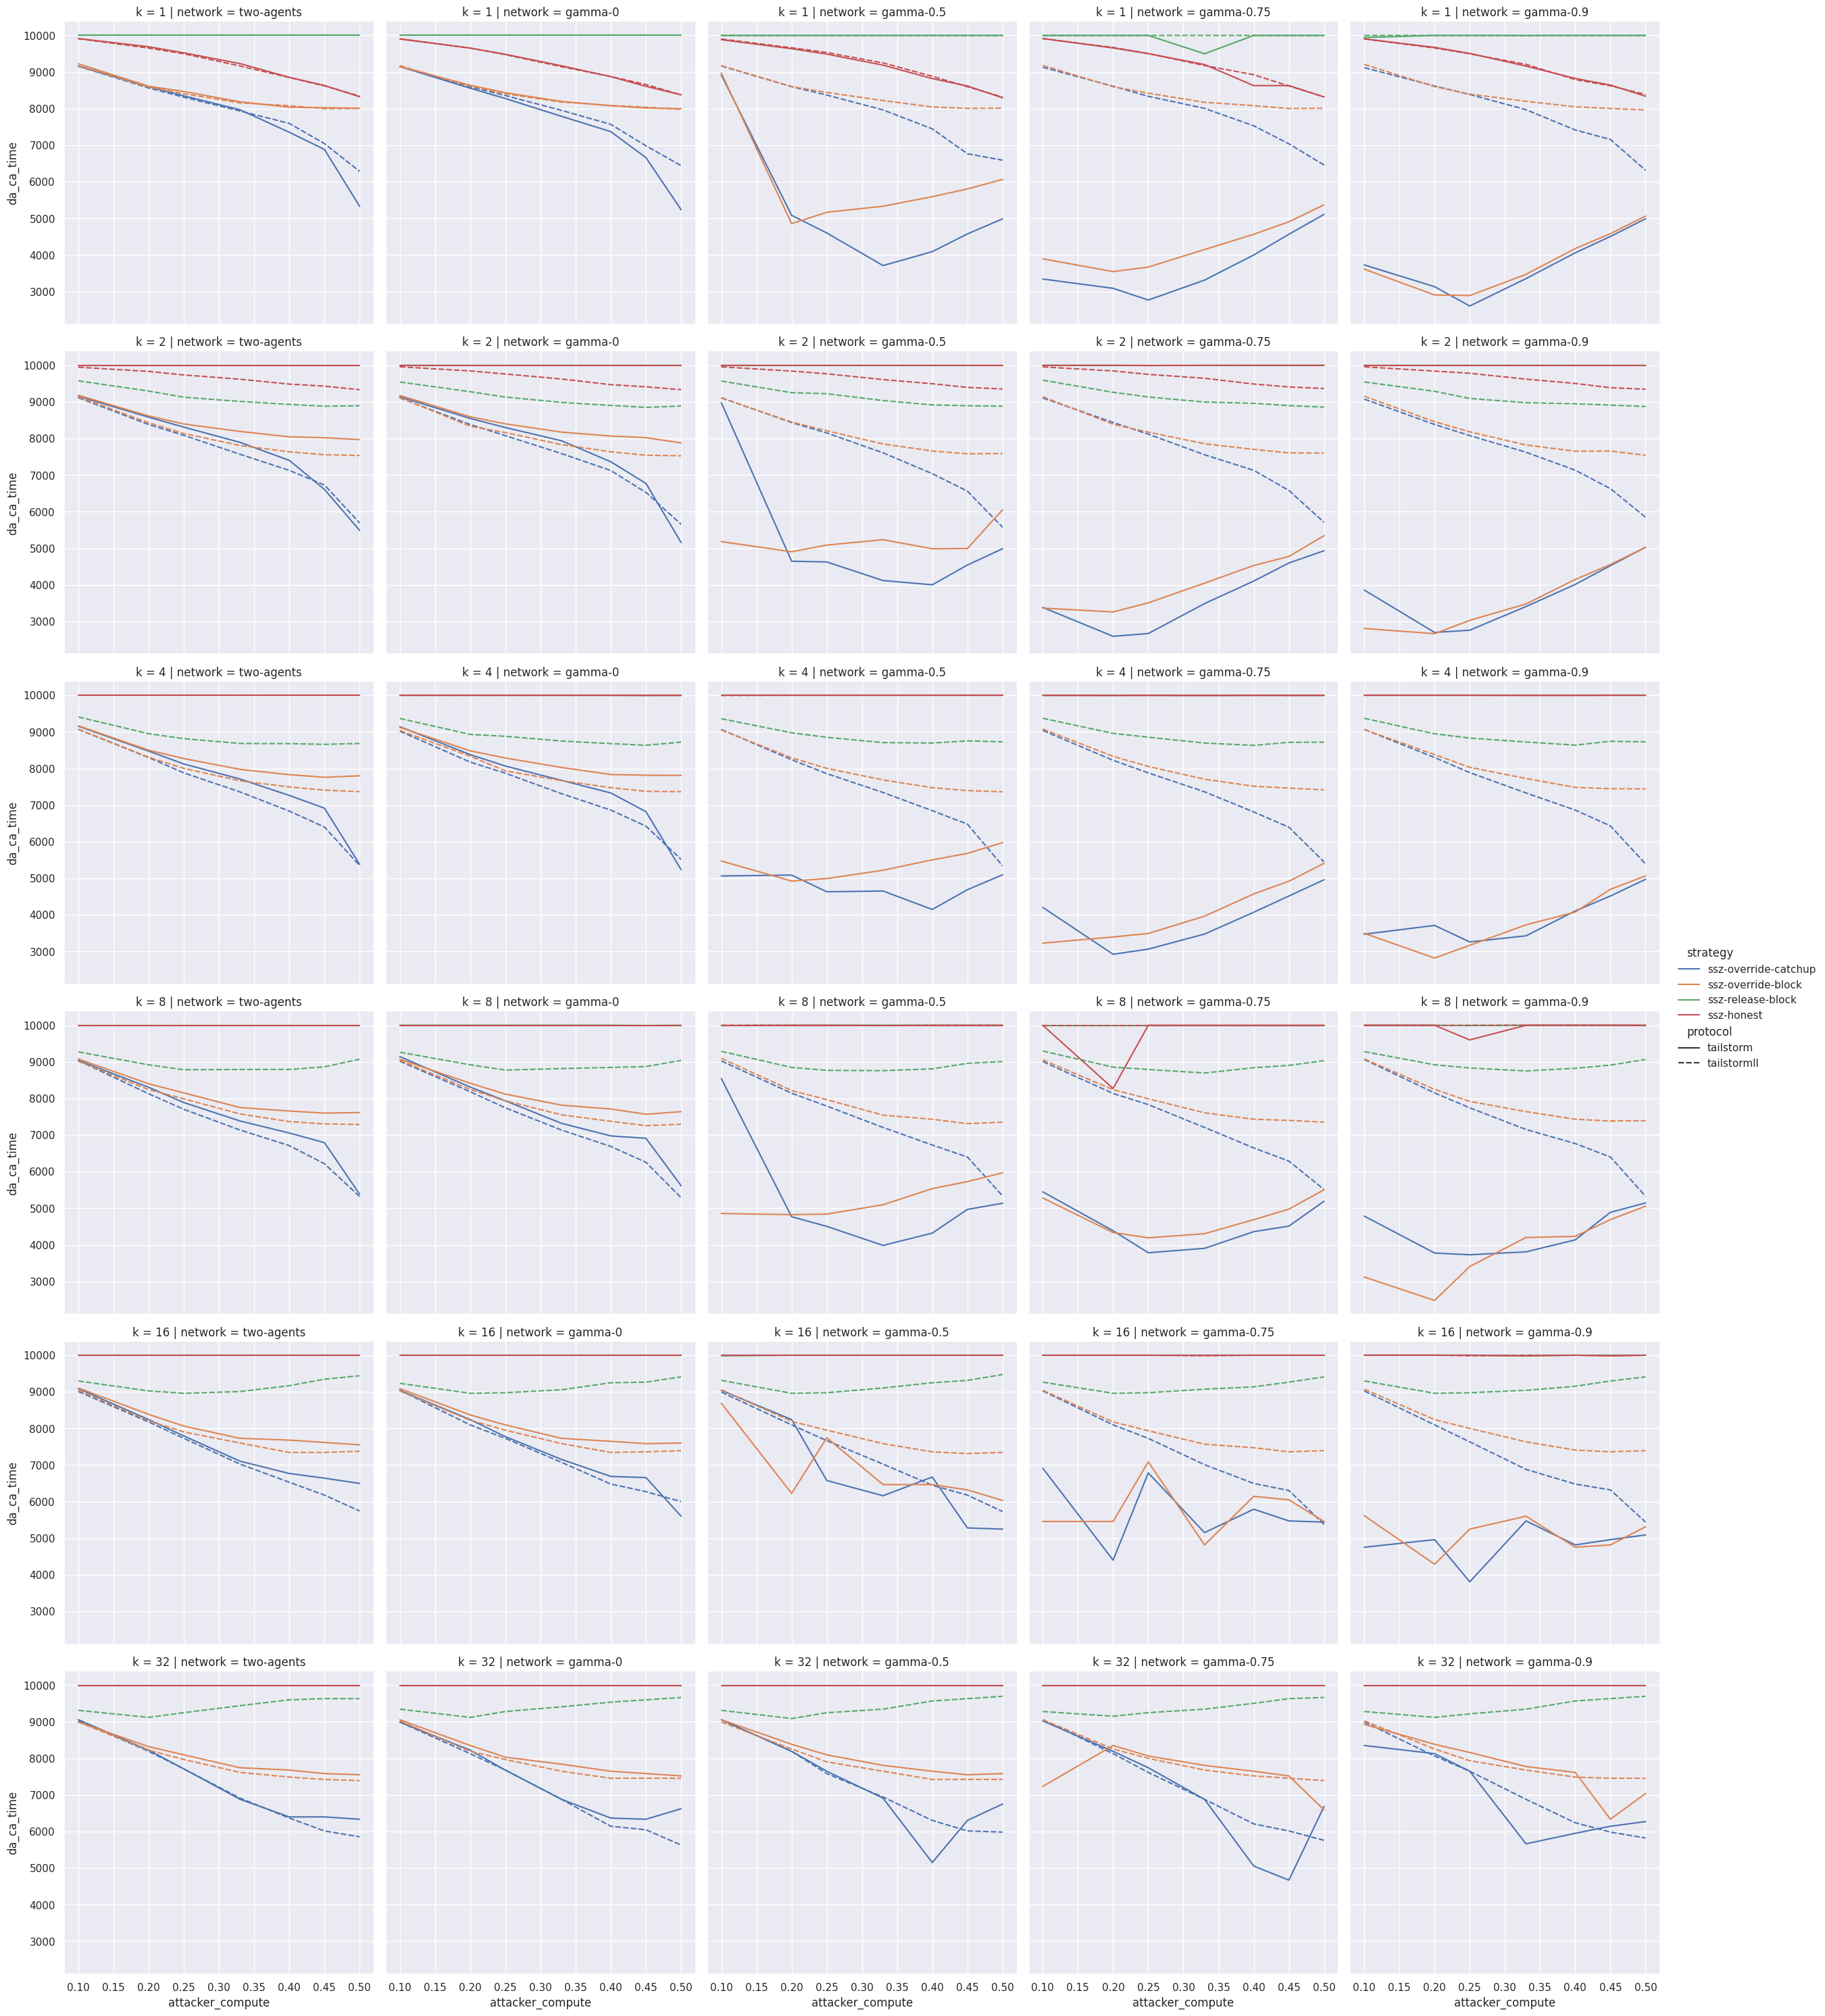

In [29]:
ax = sns.relplot(
    data=d.query('attack_space == "ssz" and incentive_scheme == "discount"'),
    x="attacker_compute",
    y="da_ca_time",
    row="k",
    col="network",
    hue="strategy",
    style="protocol",
    kind="line",
)

It's weird. Implementations almost align for the no-delay case. Higher gamma causes misalignment. For low k the difference is obvious. For high k the magnitude is comparable but the variance in tailstorm is higher. On the positive side, things seems to align neatly for the honest policy.

Let's compare rewards across protocol implementation. It should be the same, otherwise there is a bug in the new protocol implementation, its attack space, or policies.

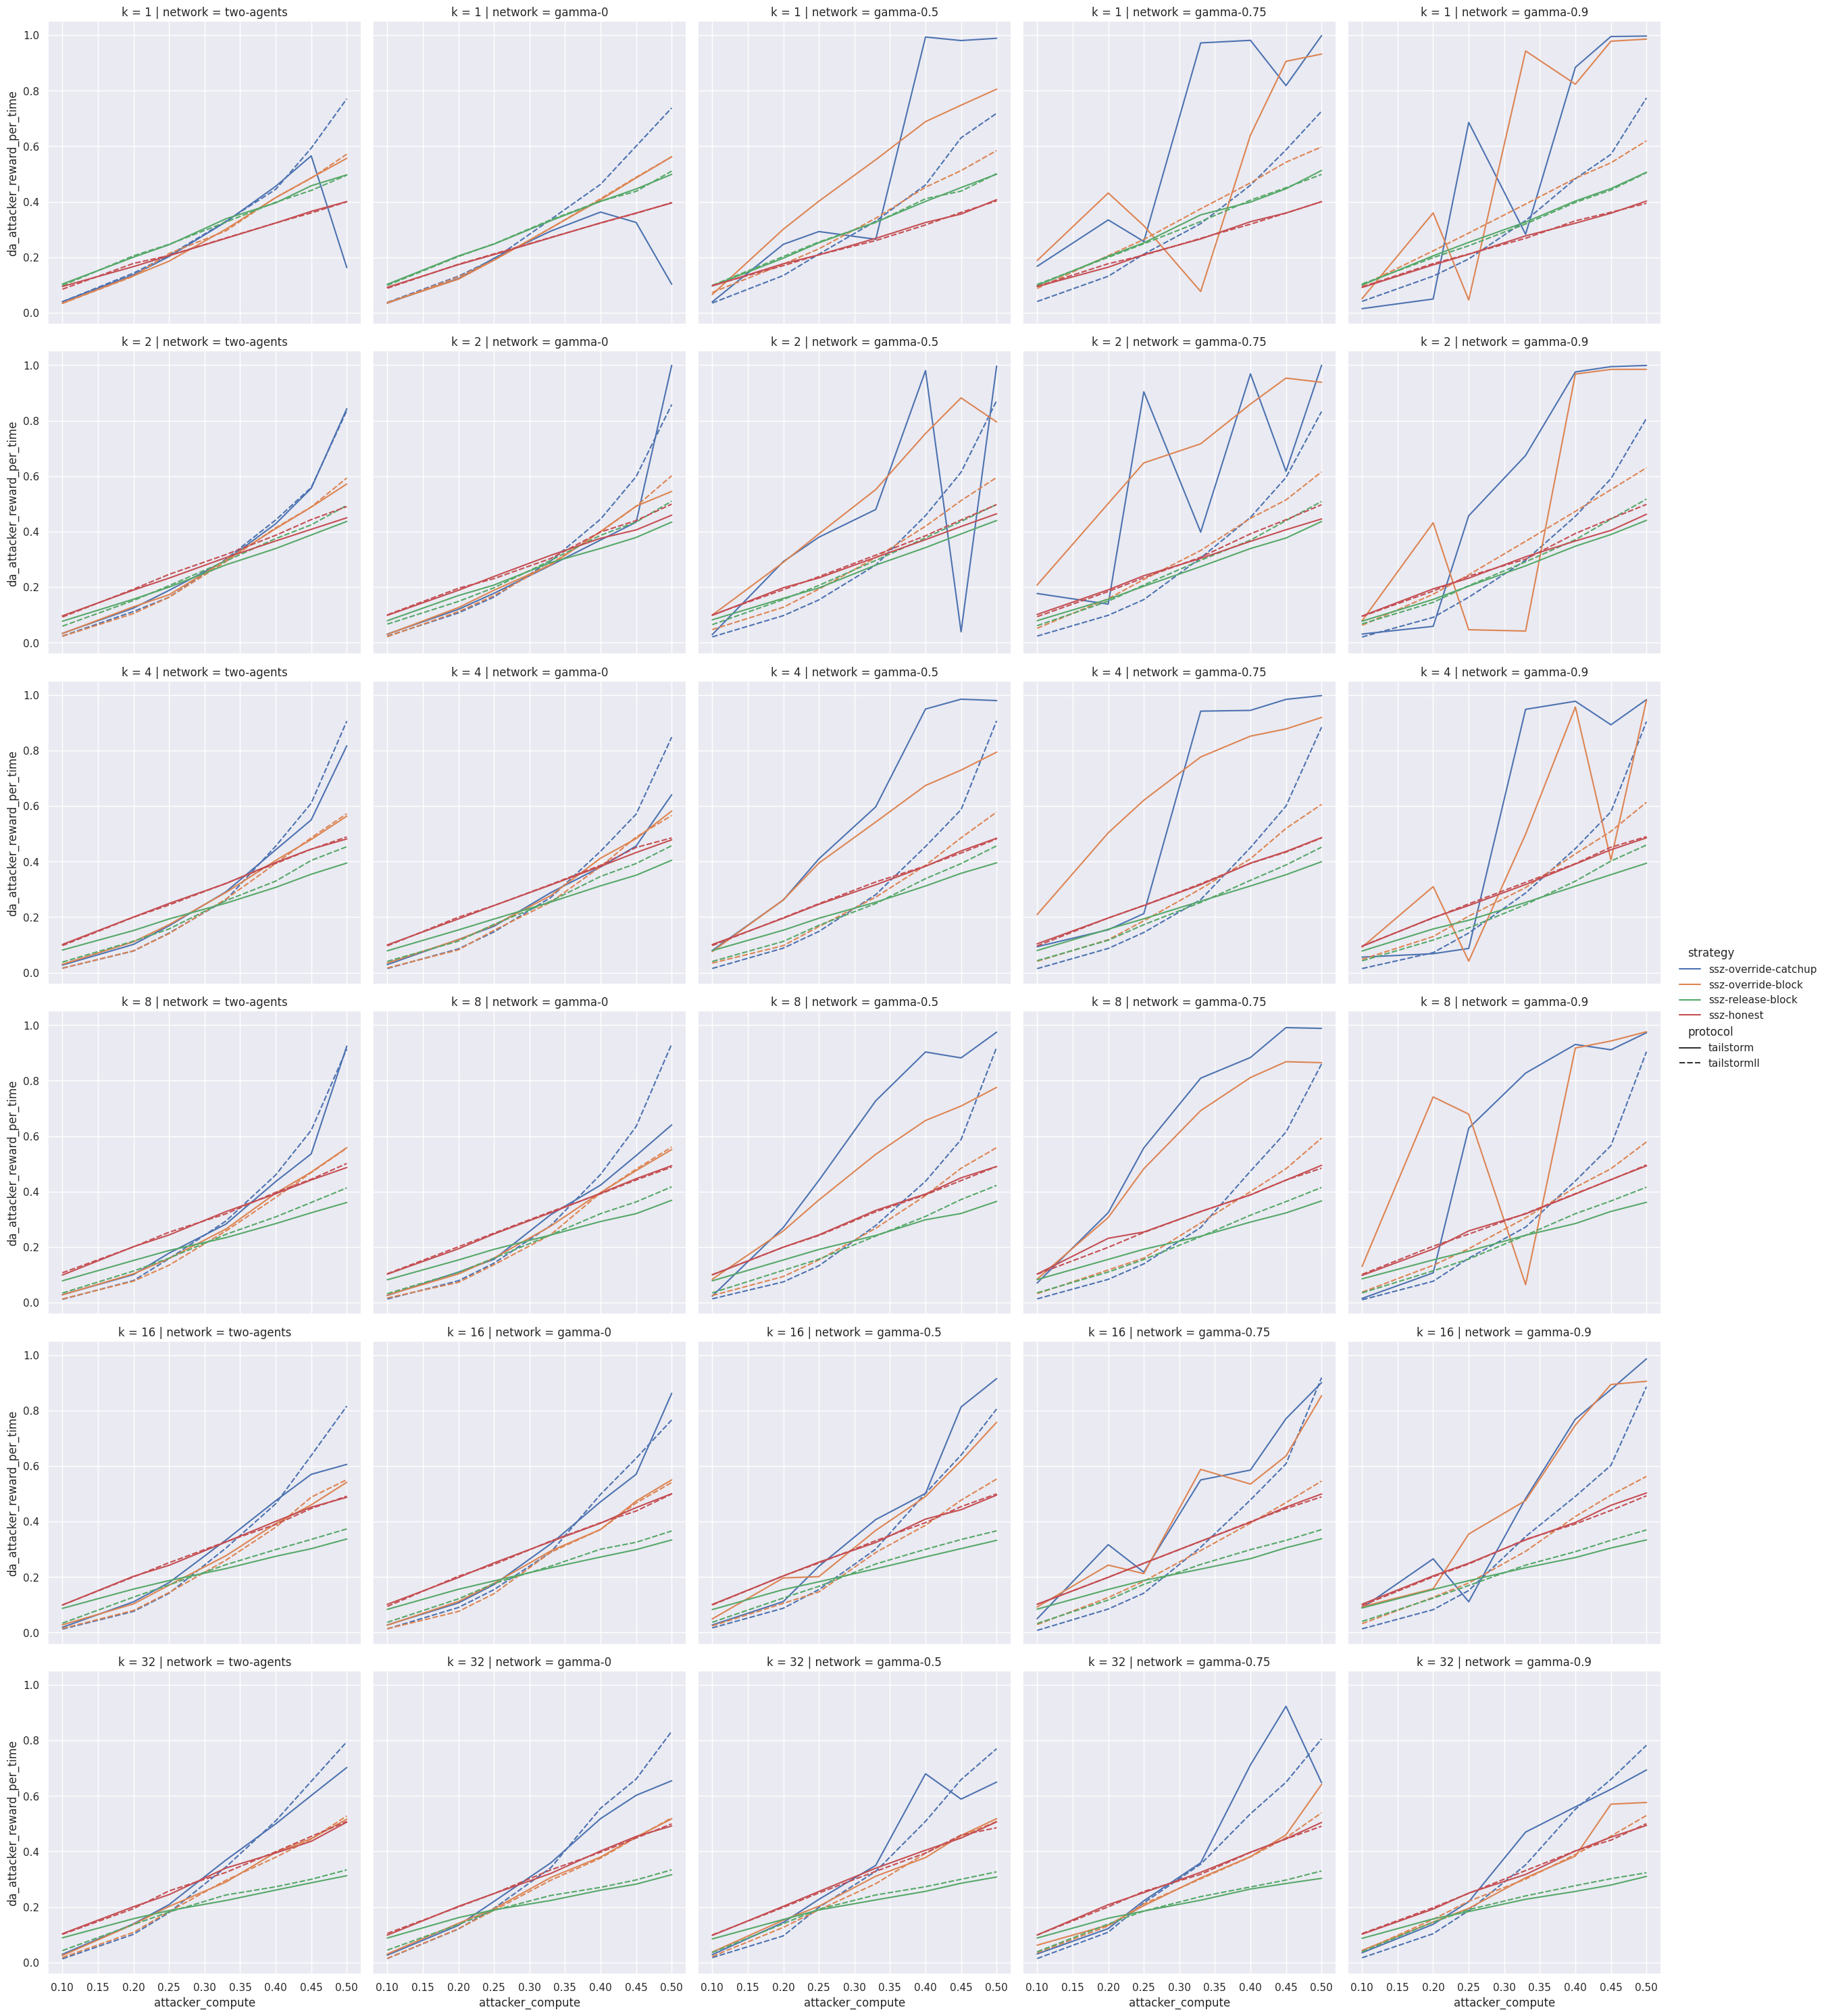

In [36]:
ax = sns.relplot(
    data=d.query('attack_space == "ssz" and incentive_scheme == "discount"'),
    x="attacker_compute",
    y="da_attacker_reward_per_time",
    row="k",
    col="network",
    hue="strategy",
    style="protocol",
    kind="line",
)

This is truly weird. I have no glue whats going on.

---

What follows is the old analysis of the old tailstorm implementation with the first attack space version. I'm producing some figures here for a report somewhere in the git repo. Thus I keep the experiment as it. At some point it should be revised though.

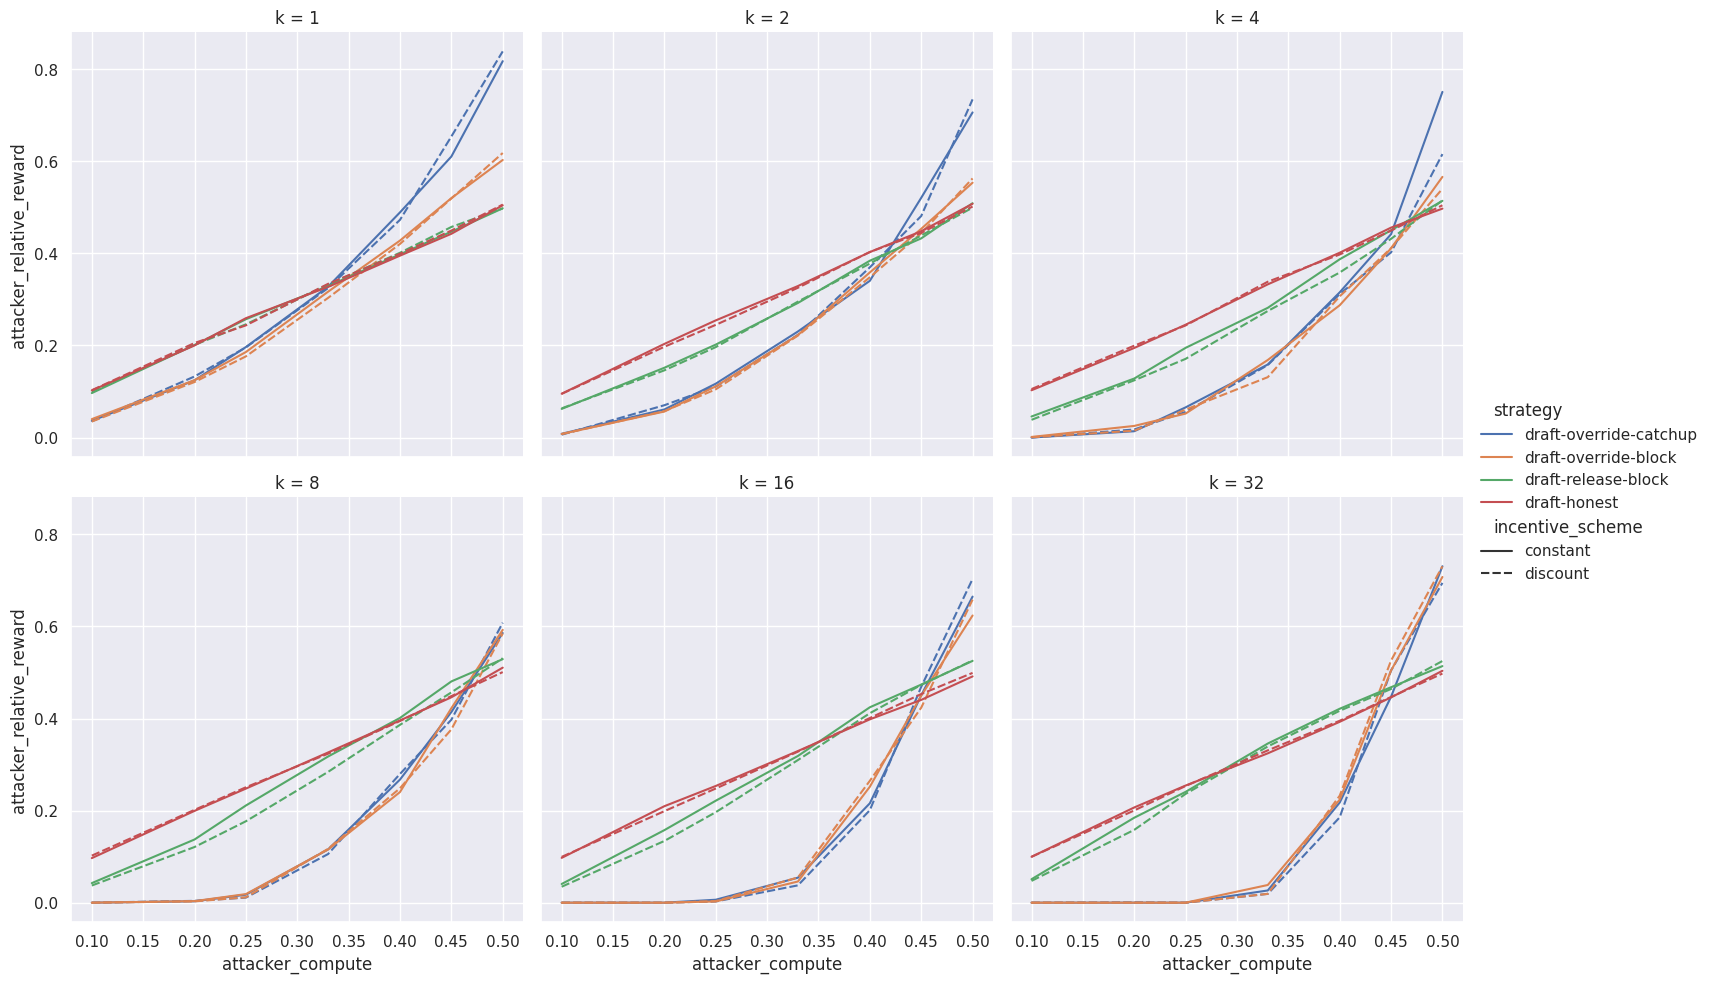

In [30]:
ax = sns.relplot(
    data=d.query('attack_space == "draft" and protocol == "tailstormll"'),
    x="attacker_compute",
    y="attacker_relative_reward",
    col="k",
    col_wrap=3,
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_relative.png")

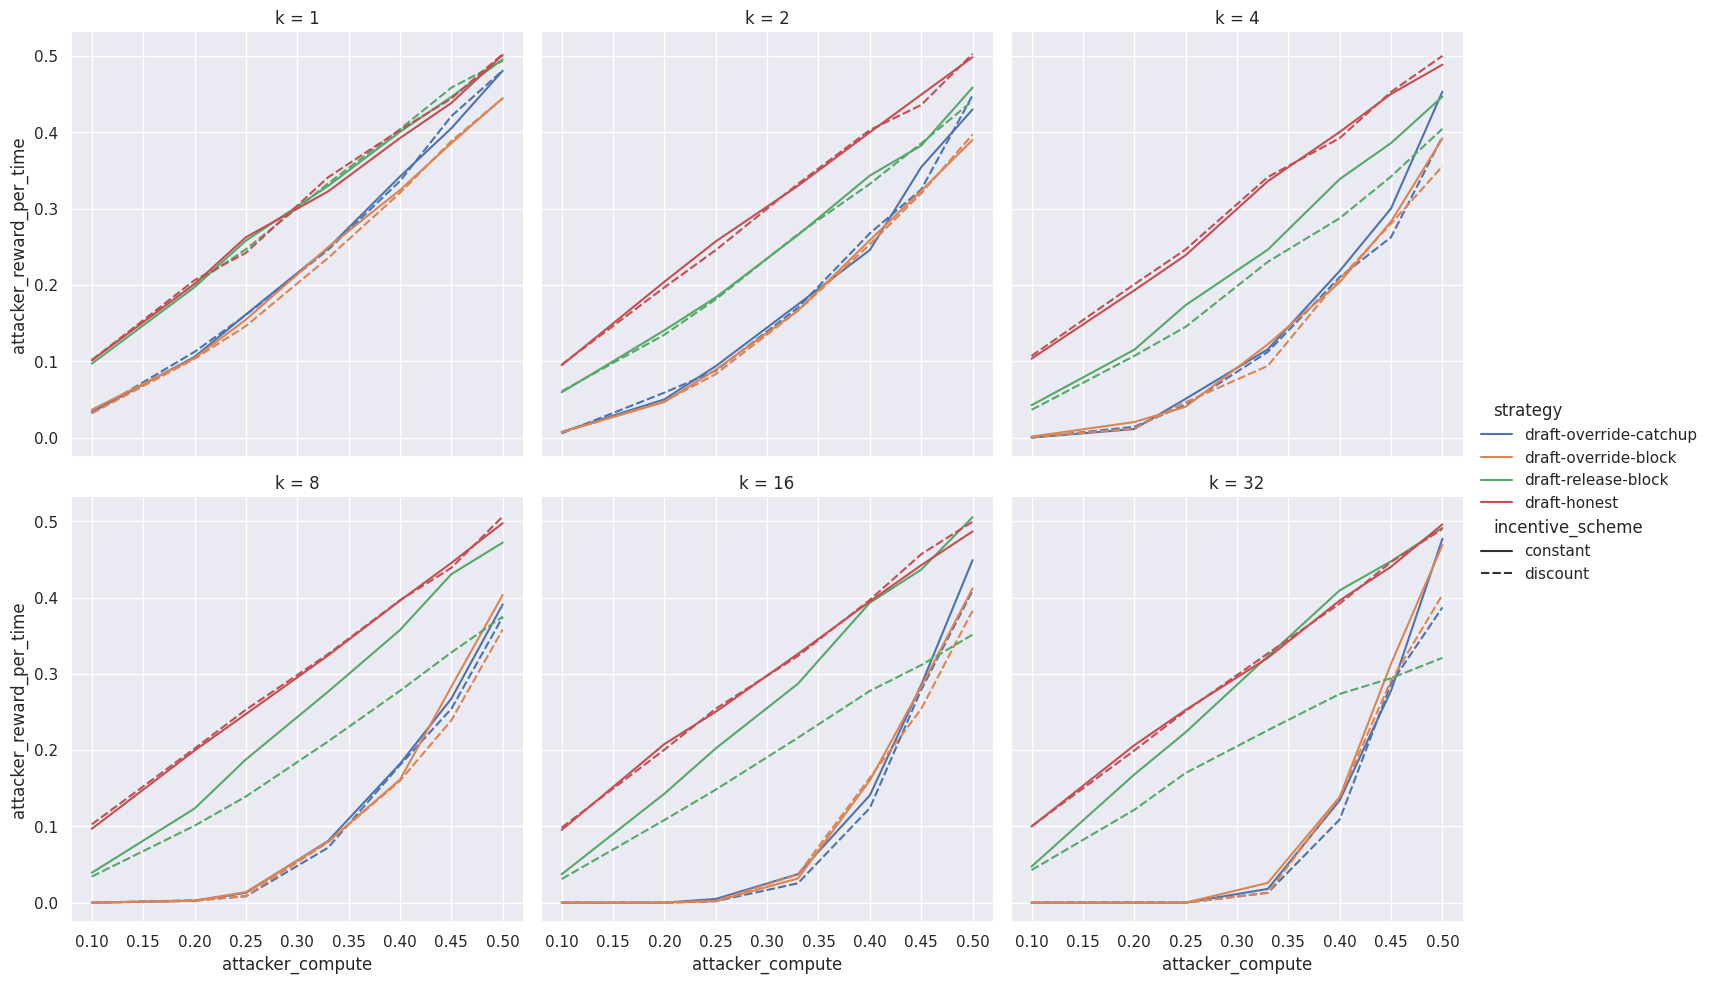

In [32]:
ax = sns.relplot(
    data=d.query('attack_space == "draft" and protocol == "tailstormll"'),
    x="attacker_compute",
    y="attacker_reward_per_time",
    col="k",
    col_wrap=3,
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_absolute.png")

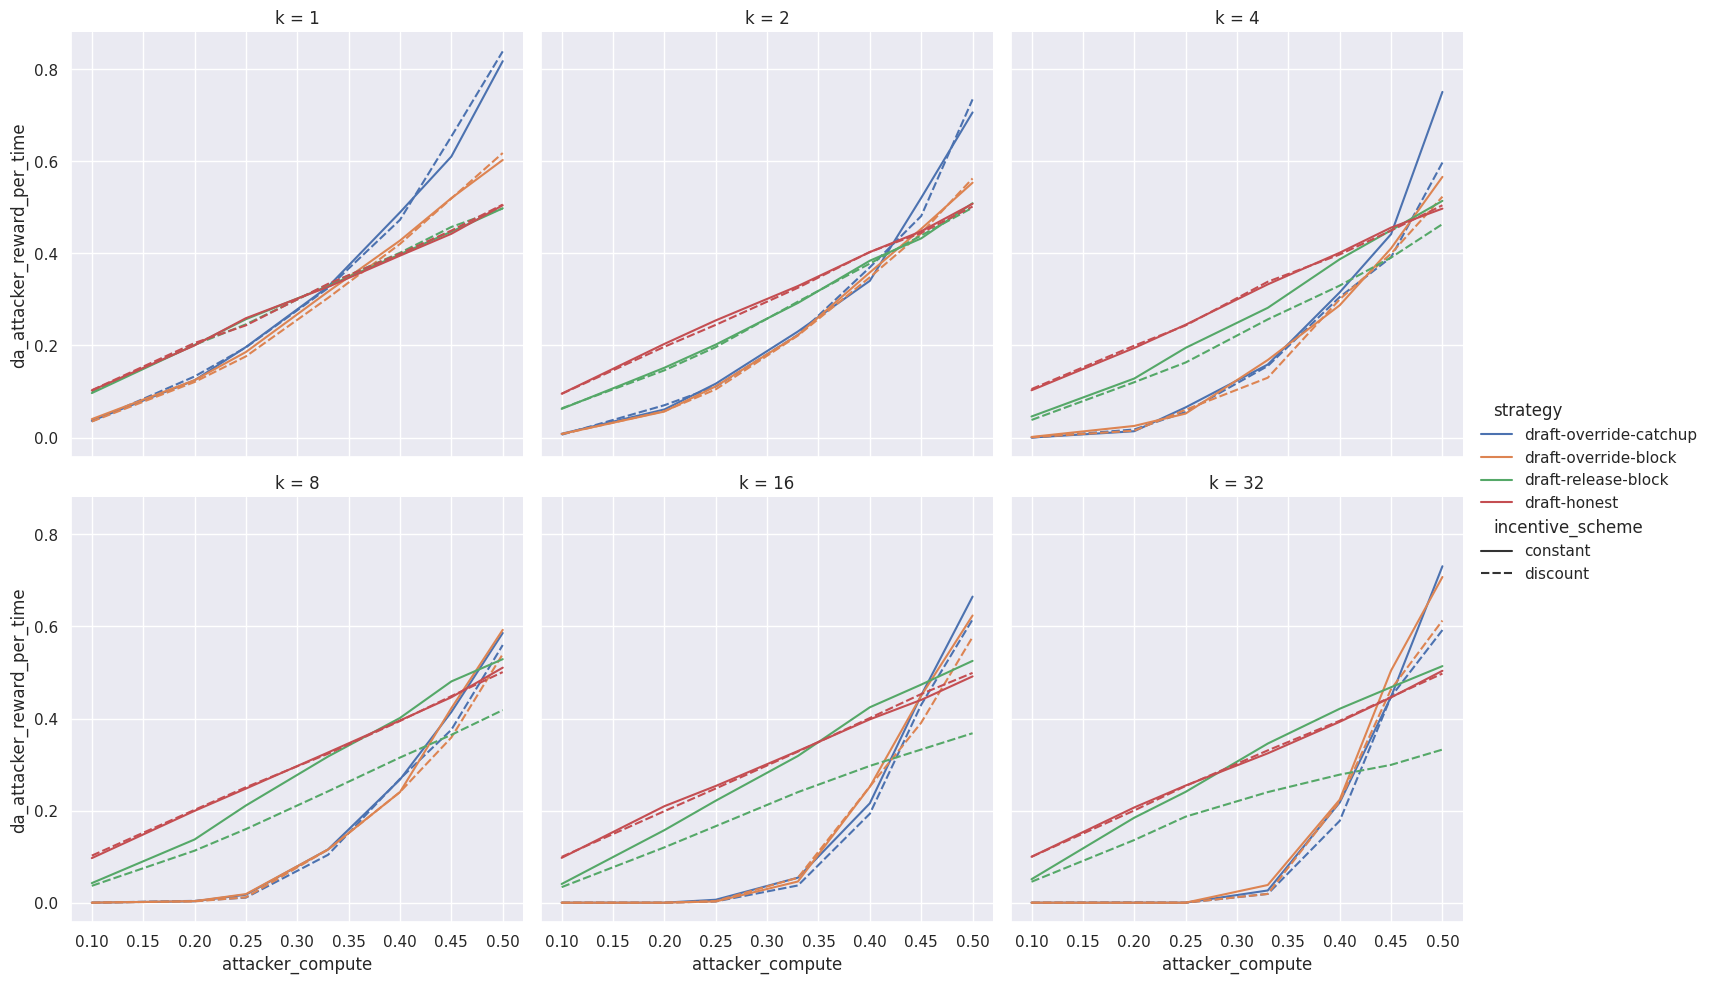

In [33]:
ax = sns.relplot(
    data=d.query('attack_space == "draft" and protocol == "tailstormll"'),
    x="attacker_compute",
    y="da_attacker_reward_per_time",
    col="k",
    col_wrap=3,
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_daa.png")

Comparision of attack spaces for Tailstorm/ll with emulated difficulty adjustment. This suggests that the ssz attack space is more powerfull than the old draft attack space. It also seems, that discount has an effect.

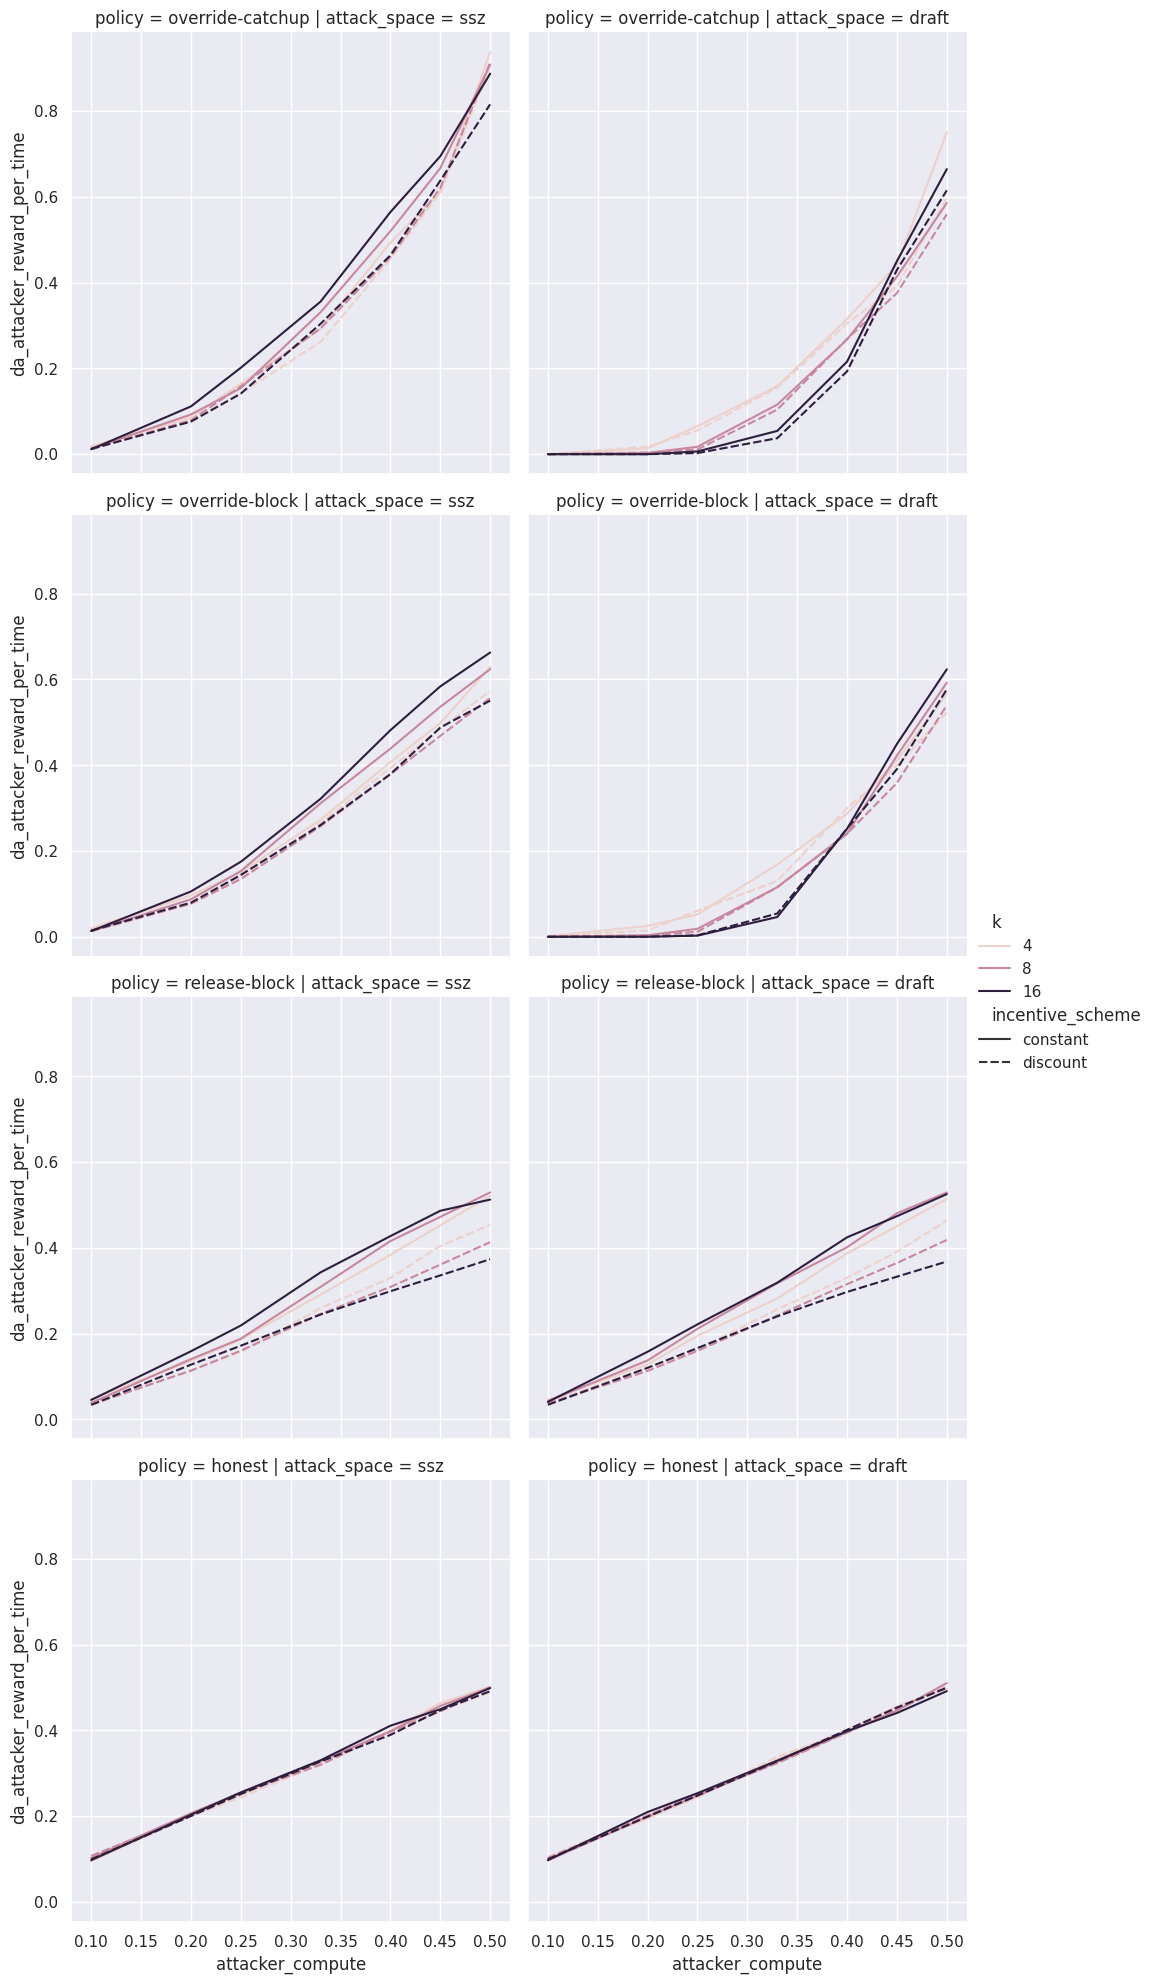

In [35]:
ax = sns.relplot(
    data=d.query(
        'protocol == "tailstormll" and k in [4,8,16] and network == "two-agents" '
    ),
    x="attacker_compute",
    y="da_attacker_reward_per_time",
    col="attack_space",
    row="policy",
    hue="k",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_daa.png")